# Sequence Mining via les chaînes de Markov et la donnée symbolique temporelle
## Application à l'analyse de logs

In [1]:
%pylab inline

pylab.rcParams['figure.figsize'] = (15.0, 10.0)
pylab.rcParams['figure.dpi'] = 150

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [3]:
import time
import datetime
import numpy as np
from scipy import stats

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

## Ingestion et transformation de la donnée

On fait un simple map entre le niveau de criticité d'un log et une valeur numérique.

In [5]:
def feature_log(x):
    
    if "INFO" in x:
        crit_val = 1
    if "WARN" in x:
        crit_val = 2
    if "ERROR" in x:
        crit_val = 3
    if "FATAL" in x:
        crit_val = 4
    if "OFF" in x:
        crit_val = 5
    
    return crit_val

La fonction `read_log` est pas top mais j'avais pas envie de la recoder. Cela permet de manger un fichier de log type log4j (des packages en python existent pour le faire tout seul).

In [33]:
import zipfile

def read_log(zip_file, filename):
    archive = zipfile.ZipFile(zip_file, 'r')
    inputfile = archive.read(filename).decode("utf8").split("\n")
    inputfile = inputfile[:-1]
    datelist = []
    infolist = []
    for line in inputfile:
        i = 0
        str_date = ''
        ok = False
        if ord(line[0]) >= ord('0') and ord(line[0]) <= ord('9'):
            ok = True
        
        if ok:
            while i < len(line):     
                c = line[i]
                if c != ',':
                    str_date += c
                else:
                    i = i+3
                    break

                i += 1

            datelist.append(str_date)
            l = len(line) - 1
            i+=1
            infolist.append(line[i:l])

    
    X = pd.DataFrame()
    X['timestamp'] = datelist
    X['infos'] = infolist
    
    return X

La donnée qu'on ingère est une série de logs HDFS d'un joli cluster Hadoop. On transforme les niveaux de criticité en numérique, et on transforme les timestamps en timestamps unix.

In [34]:
logs = read_log('../data/hdfs_logs.zip', 'hdfs_logs/hdfs_logs.out')
logs.head(5)

b'2014-05-01 18:14:15,733 INFO org.apache.hadoop.hdfs.server.datanode.fsdataset.impl.FsDatasetAsyncDiskService: Deleted BP-896807106-10.142.128.108-1385397273421 blk_4824452291913802518_508476 file /pprd/HDOP/data/04/dfs/dn/current/BP-896807106-10.142.128.108-1385397273421/current/finalized/blk_4824452291913802518\n2014-05-01 18:14:21,290 INFO org.apache.hadoop.hdfs.server.datanode.BlockPoolSliceScanner: Verification succeeded for BP-896807106-10.142.128.108-1385397273421:blk_8928884118525255236_274715\n2014-05-01 18:14:21,291 INFO org.apache.hadoop.hdfs.server.datanode.BlockPoolSliceScanner: Verification succeeded for BP-896807106-10.142.128.108-1385397273421:blk_-7638255093294703263_34844\n2014-05-01 18:14:33,090 INFO org.apache.hadoop.hdfs.server.datanode.BlockPoolSliceScanner: Verification succeeded for BP-896807106-10.142.128.108-1385397273421:blk_8230062146741508304_285483\n2014-05-01 18:14:33,091 INFO org.apache.hadoop.hdfs.server.datanode.BlockPoolSliceScanner: Verification suc

TypeError: 'int' object is not subscriptable

In [8]:
logs['crit_level'] = logs['infos'].map(lambda x : feature_log(x))
logs = logs[logs['crit_level'] != 0]

In [9]:
logs['u_timestamp'] = logs['timestamp'].map(lambda x : time.mktime(datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").timetuple()))

In [10]:
logs.head(5)

,timestamp,infos,crit_level,u_timestamp
0,2014-05-01 18:14:15,INFO org.apache.hadoop.hdfs.server.datanode.f...,1,1.398961e+09
1,2014-05-01 18:14:21,INFO org.apache.hadoop.hdfs.server.datanode.B...,1,1.398961e+09
2,2014-05-01 18:14:21,INFO org.apache.hadoop.hdfs.server.datanode.B...,1,1.398961e+09
3,2014-05-01 18:14:33,INFO org.apache.hadoop.hdfs.server.datanode.B...,1,1.398961e+09
4,2014-05-01 18:14:33,INFO org.apache.hadoop.hdfs.server.datanode.B...,1,1.398961e+09


In [12]:
len(logs)

439752

Plusieurs events peuvent avoir lieu sur le même timestamp, on les aggrège.

In [13]:
logs_agg = logs.groupby('u_timestamp')[['crit_level']].mean().round()
logs_agg = logs_agg.reset_index()

On vient au passage de réduire la volumétrie :)

In [14]:
len(logs_agg)

179016

In [15]:
logs_agg.head(5)

,u_timestamp,crit_level
0,1.398961e+09,1.0
1,1.398961e+09,1.0
2,1.398961e+09,1.0
3,1.398961e+09,1.0
4,1.398961e+09,1.0


On considère arbitrairement une anomalie comme une criticité de 3 ou plus.

In [16]:
logs_agg['anomaly'] = logs_agg['crit_level'].map(lambda x : True if x >= 3 else np.nan)

In [17]:
logs_agg['anomaly'].value_counts()

True    110
Name: anomaly, dtype: int64

On fait un peu de padding arrière sur les anomalies, l'idée est que c'est gagné si on detecte une anomalie avant qu'elle arrive, dans ce cas 10 events avant.

In [18]:
logs_agg['anomaly'] = logs_agg['anomaly'].fillna(method='bfill', limit=10)

On laisse les autres lignes à `False`.

In [19]:
logs_agg['anomaly'] = logs_agg['anomaly'].fillna(value=False)

Ensuite on catégorise les anomalies et non-anomalies par un ID unique. A chaque changement de phase, on incrémente l'ID.

In [20]:
logs_agg['anomaly_id']  = (logs_agg['anomaly'] != logs_agg['anomaly'].shift()).cumsum()

In [21]:
logs_agg.anomaly.value_counts()

False    178712
True        304
Name: anomaly, dtype: int64

In [22]:
logs_agg.head(5)

,u_timestamp,crit_level,anomaly,anomaly_id
0,1.398961e+09,1.0,False,1
1,1.398961e+09,1.0,False,1
2,1.398961e+09,1.0,False,1
3,1.398961e+09,1.0,False,1
4,1.398961e+09,1.0,False,1


## Analyse ML

In [1]:
from bdacore.timeseries import MetaSequenceMiner

### Utilisation du modèle pour de la prédiction

In [24]:
x_train = logs_agg.head(int(len(logs_agg)*0.90)).copy()
x_test = logs_agg.tail(len(logs_agg) - len(x_train)).copy()

In [25]:
len(x_test)

17902

In [26]:
metaseqminer = MetaSequenceMiner(bins=40)
metaseqminer.fit(x_train[['crit_level', 'u_timestamp']].as_matrix())

MetaSequenceMiner(bins=40)

In [27]:
%%time
logs_anomalies = metaseqminer.predict_proba(x_test[['crit_level', 'u_timestamp']].as_matrix(), operation=np.max)

CPU times: user 2.09 s, sys: 10.1 ms, total: 2.1 s
Wall time: 2.11 s


*Remarque:* l'opérateur max est tout à fait criticable. Dans ce cas, comme le MetaSequenceMiner est composé d'une partie markovienne (MarkovSequenceMiner) et d'une partie temporelle (TimeDurationSequenceMiner), on garde la probabilité d'occurence la plus haute (on fait confiance au modèle qui sort le plus haut taux de confiance, par exemple si l'un des 2 modèles sort 0.9 et l'autre 0.6, on a plutôt tendance à dire que le prochain event a une forte proba d'arriver).

De base, les modèles sortent des probas d'occurences, donc pour avoir une anomalie, il faut une forte proba de non-occurence (d'où le 1-p).

In [28]:
x_test['predicted_anomalies'] = 1 - logs_anomalies

On sort les scores intermédiaires pour l'explication.

In [31]:
x_test['predicted_anomalies_markov'] = 1 - metaseqminer.markovseqminer.chained_p_
x_test['predicted_anomalies_time'] = 1 - metaseqminer.timeseqminer.time_p_

In [32]:
x_test.head(5)

,u_timestamp,crit_level,anomaly,anomaly_id,predicted_anomalies,predicted_anomalies_markov,predicted_anomalies_time
161114,1.406033e+09,1.0,False,33,0.000000,0.000000,0.000000
161115,1.406033e+09,1.0,False,33,0.002733,0.002733,0.008496
161116,1.406033e+09,1.0,False,33,0.003908,0.003908,0.008496
161117,1.406034e+09,1.0,False,33,0.004435,0.004435,0.008496
161118,1.406034e+09,1.0,False,33,0.004687,0.004687,0.008496


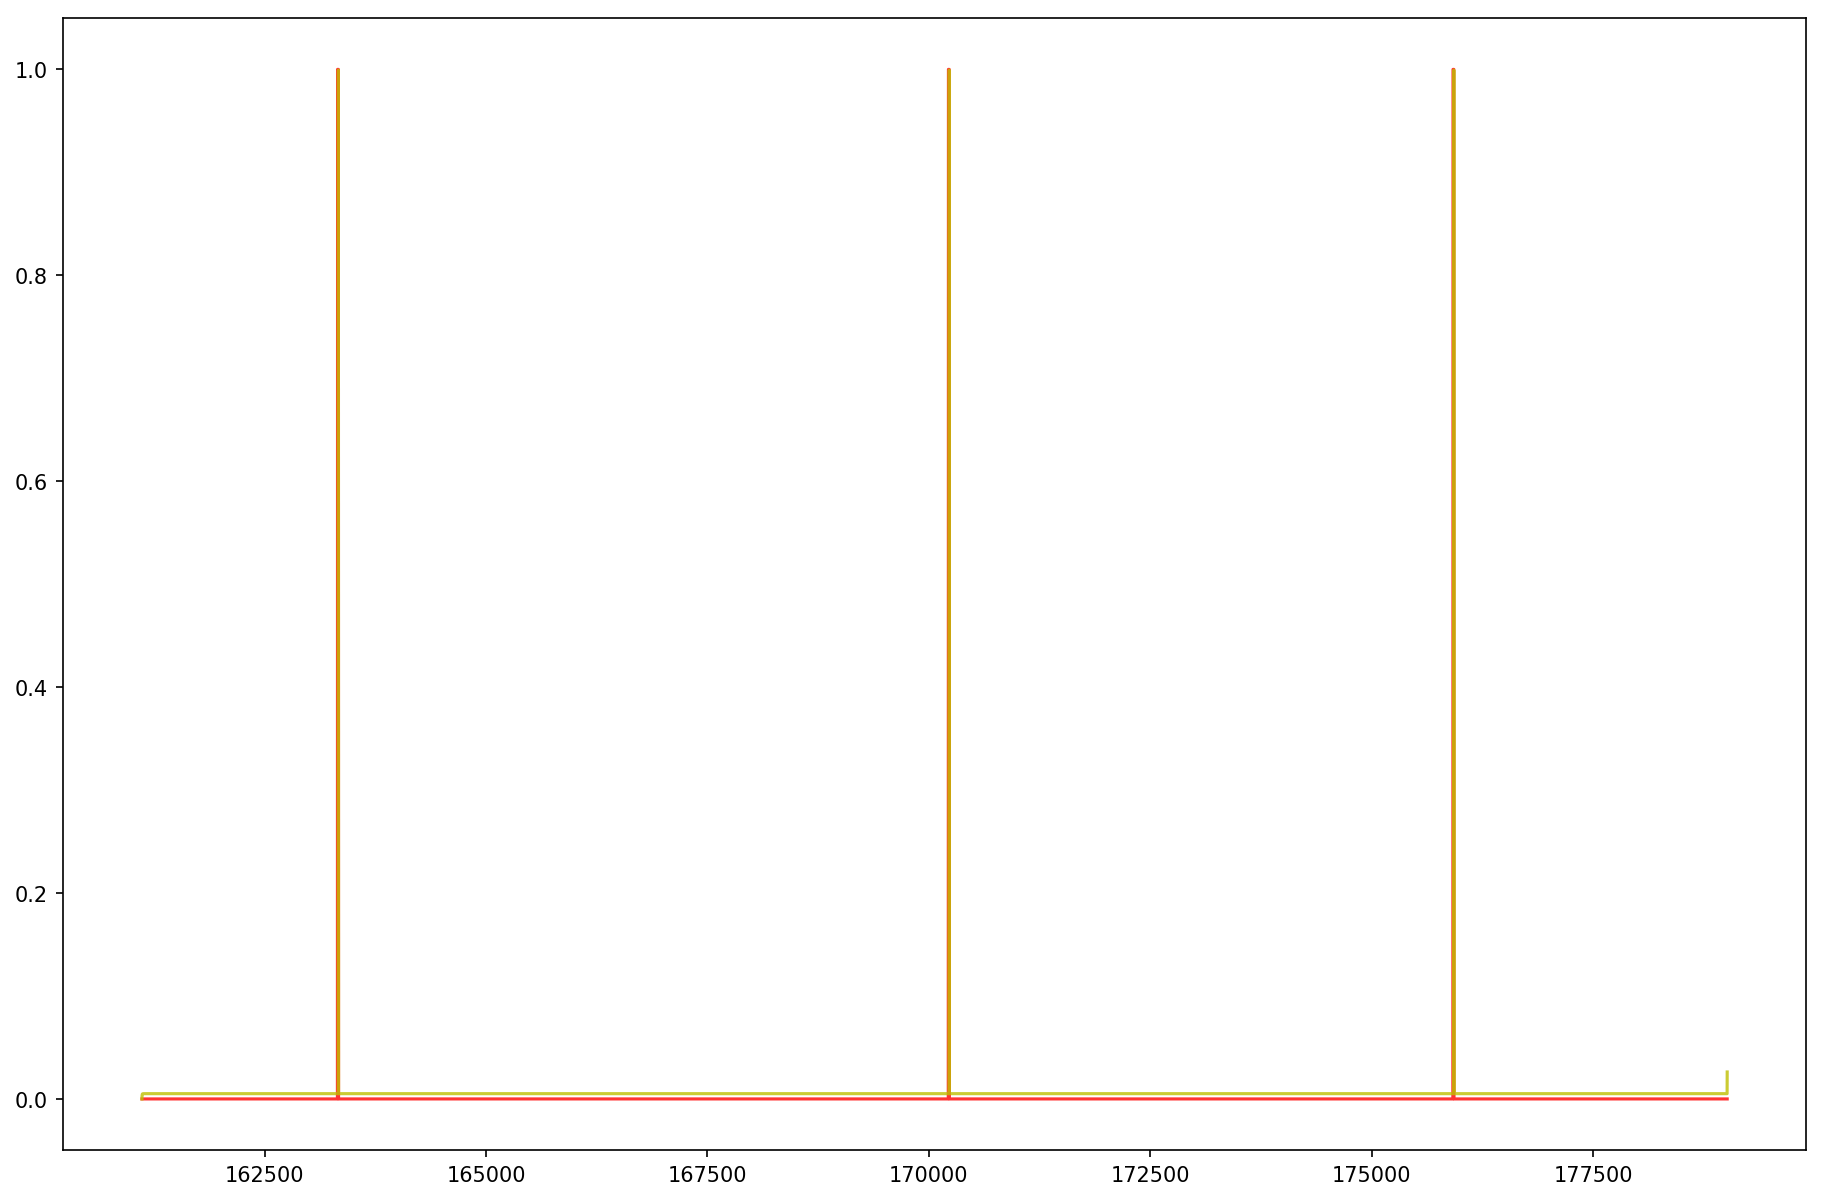

In [35]:
plt.plot(x_test.anomaly, c='r', alpha=0.8)
plt.plot(x_test.predicted_anomalies, c='y', alpha = 0.8)

Sans surprise, ça trouve bien les anomalies, mais ici, autant regarder les events avec une criticité de 3 ou plus, ca revient au même...

Si on check uniquement la partie temporelle:

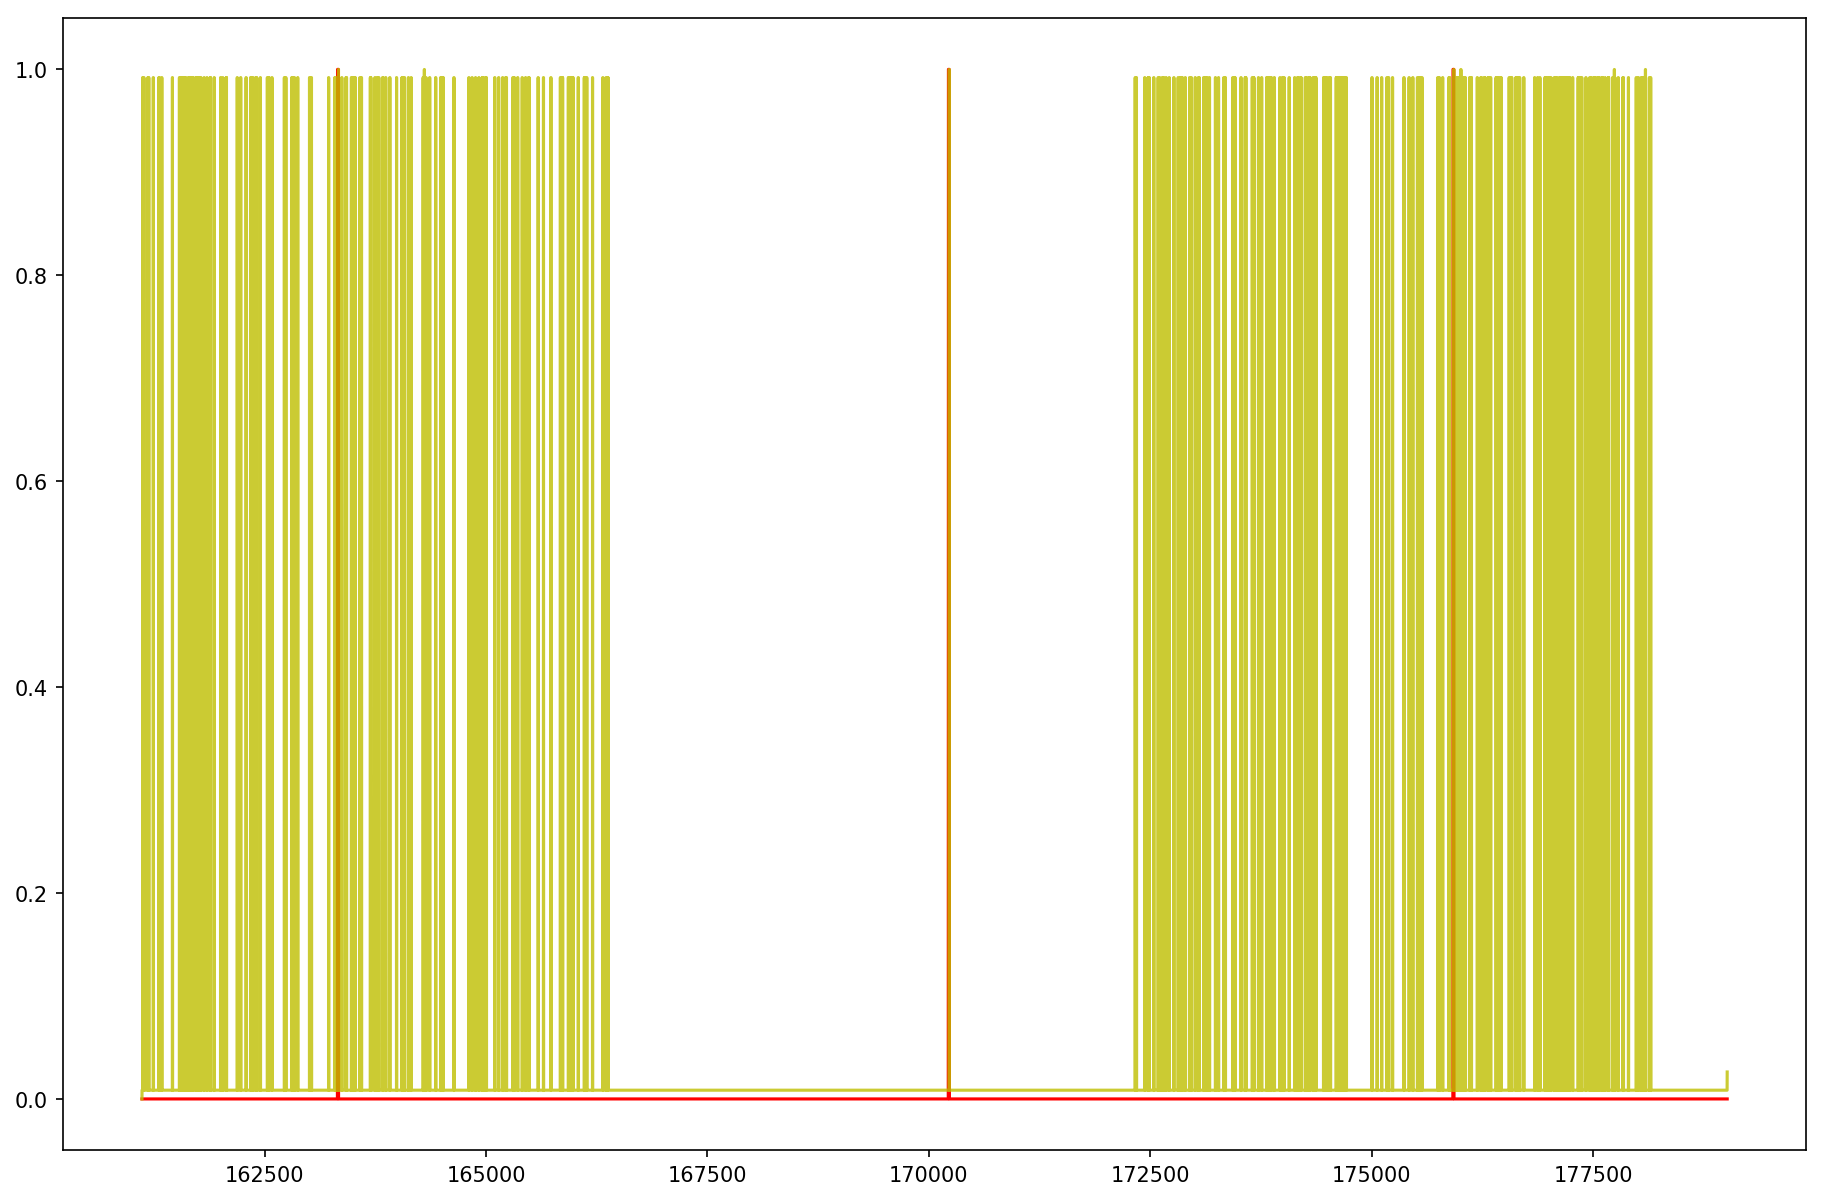

In [36]:
plt.plot(x_test.anomaly, c='r')
plt.plot(x_test.predicted_anomalies_time, c='y', alpha = 0.8)

C'est plus intéressant car autour de 2 anomalies sur 3, on a un comportement temporel non-habituel, qui pourrait donc servir comme signal pour décider.

On fait comme si on mesurait pour de vrai (si vous voulez faire des tests, au moins le code existe), mais on sait déjà qu'on a bon :|

In [37]:
x_test['predicted_anomalies_TF'] = x_test['predicted_anomalies'] > 0.3

In [38]:
x_test = x_test.reset_index(drop=True)

In [39]:
y_true = x_test.groupby('anomaly_id')['anomaly'].max()
y_test = x_test.groupby('anomaly_id')['predicted_anomalies'].max()
y_test_bin = x_test.groupby('anomaly_id')['predicted_anomalies_TF'].max()

In [40]:
y_test_bin.value_counts()

False    4
True     3
Name: predicted_anomalies_TF, dtype: int64

In [41]:
y_true.value_counts()

False    4
True     3
Name: anomaly, dtype: int64

In [42]:
pd.DataFrame([y_true, y_test, y_test_bin]).transpose()

,anomaly,predicted_anomalies,predicted_anomalies_TF
anomaly_id,,,
33,0.0,0.005127,0.0
34,1.0,0.999336,1.0
35,0.0,0.005127,0.0
36,1.0,0.999336,1.0
37,0.0,0.005127,0.0
38,1.0,0.999336,1.0
39,0.0,0.026190,0.0


In [43]:
print(classification_report(y_true, y_test_bin))

             precision    recall  f1-score   support

      False       1.00      1.00      1.00         4
       True       1.00      1.00      1.00         3

avg / total       1.00      1.00      1.00         7



Rien de très glorieux puisque la quasi totalité du signal est porté par le changement d'état... que le modèle n'a pas anticipé.

### Utilisation du modèle pour de l'analyse

Cette fois, on fit et on predict sur l'ensemble de la donnée (plutôt analyse non-supervisée)

In [44]:
metaseqminer = MetaSequenceMiner(bins=5)
metaseqminer.fit(logs_agg[['crit_level', 'u_timestamp']].as_matrix())

MetaSequenceMiner(bins=5)

In [45]:
%%time
logs_anomalies = metaseqminer.predict_proba(logs_agg[['crit_level', 'u_timestamp']].as_matrix(), operation=np.max)

CPU times: user 15.6 s, sys: 63 ms, total: 15.7 s
Wall time: 15.8 s


In [48]:
logs_agg['predicted_anomalies'] = 1 - logs_anomalies

In [49]:
logs_agg['predicted_anomalies_TF'] = logs_agg['predicted_anomalies'] > 0.3

In [50]:
y_true = logs_agg.groupby('anomaly_id')['anomaly'].max()
y_test = logs_agg.groupby('anomaly_id')['predicted_anomalies'].max()
y_test_bin = logs_agg.groupby('anomaly_id')['predicted_anomalies_TF'].max()

In [51]:
pd.DataFrame([y_true, y_test, y_test_bin]).transpose()

,anomaly,predicted_anomalies,predicted_anomalies_TF
anomaly_id,,,
1,0.0,0.004751,0.0
2,1.0,0.333333,1.0
3,0.0,0.004641,0.0
4,1.0,0.333333,1.0
5,0.0,0.020202,0.0
6,1.0,0.500000,1.0
7,0.0,0.004751,0.0
8,1.0,0.333333,1.0
9,0.0,0.020202,0.0


In [52]:
print(classification_report(y_true, y_test_bin))

             precision    recall  f1-score   support

      False       1.00      0.85      0.92        20
       True       0.86      1.00      0.93        19

avg / total       0.93      0.92      0.92        39



In [53]:
fpr, tpr, _ = roc_curve(y_true.values, y_test.values)

In [54]:
auc(fpr, tpr)

0.8684210526315789

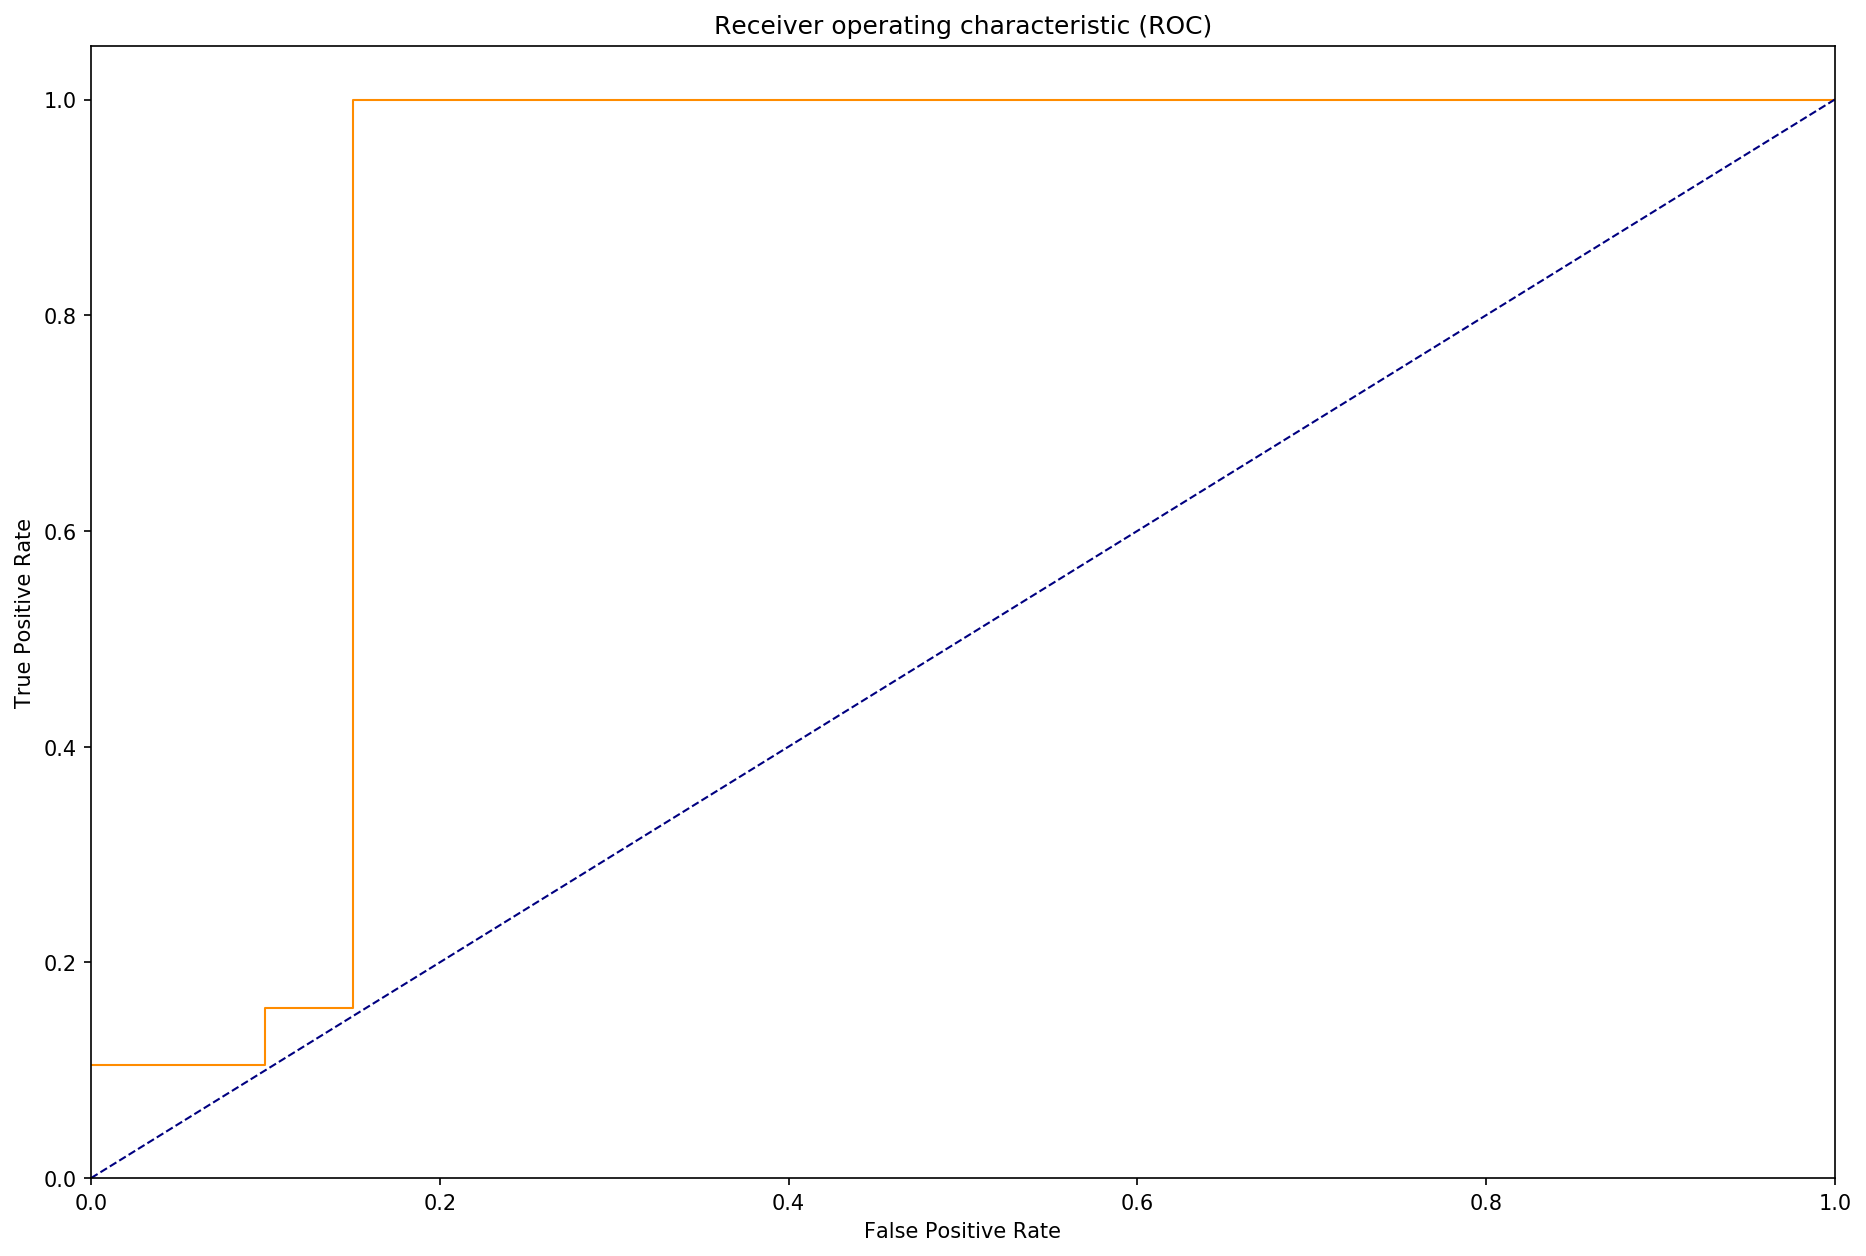

In [55]:
plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.show()

#### Debrief:
Cela se comporte mieux pour de l'analyse de causes que pour de la prédiction pure dans ce scénario (même si l'aspect temporel peut aider). Il faut cependant garder à l'esprit qu'utiliser ce type d'approche en mode "supervisé" sous-entend que le dataset d'apprentissage correspond au fonctionnement normal du système étudié, car si ce n'est pas le cas (apprentissage sur un dataset bourré d'anomalies), il apprendra l'anomalie et détectera plutôt la non-anomalie. Avec un historique suffisant, cette hypothèse est heureusement souvent vérifiée (anomalie = évènement rare).

L'aspect paramétrique peut aussi poser problème ==> quel seuil de probabilité choisir pour étiqueter la ligne comme une anomalie prédite ? (ici, on a pris la valeur 0.3 arbitrairement).